In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from vcm.catalog import catalog
import intake
import fsspec
import xarray as xr
import numpy as np

from vcm.fv3.metadata import standardize_fv3_diagnostics

SECONDS_PER_DAY = 86400


In [2]:
grid = catalog["grid/c48"].read()
area = grid["area"]

land_sea_mask = catalog["landseamask/c48"].read()["land_sea_mask"]
area_land_mask = area.where(land_sea_mask==1)

In [3]:
verif_physics =  standardize_fv3_diagnostics(catalog['40day_c48_gfsphysics_15min_may2020'].to_dask())
verif_physics["total_precip_to_surface"] = verif_physics["PRATEsfc"] * SECONDS_PER_DAY

verif_physics["total_precip_to_surface_spatial_mean_physics_land"]= (
    (verif_physics["total_precip_to_surface"] * area_land_mask).sum(skipna=True, dim=["tile", "x", "y"]) 
    / area_land_mask.sum(skipna=True)
)

In [29]:
"""
experiments = [
    "training-control-ml-tendencies-only-RF",
    "training-prescribed-ml-tendencies-rad-RF",
    "training-prescribed-ml-tendencies-rad-NN",
    "baseline",
]
paths = [
    f"gs://vcm-ml-public/argo/prog-report-nudge-to-3km-sensitivity/{experiment}"
    for experiment in experiments
]
"""

experiments = [
    "Tq-RF",
    "TqR-RF",
    "TqR-NN",
    "TquvR-NN",
    "base-no-ML",
]
paths = [
    "gs://vcm-ml-public/argo/prog-report-nudge-to-3km-ablation-runs/temperature-moisture-RF",
    "gs://vcm-ml-public/argo/prog-report-nudge-to-3km-compare-dq1-dq2-only/random_forests_dQ1_dQ2_only",
    "gs://vcm-ml-public/argo/prog-report-nudge-to-3km-compare-dq1-dq2-only/neural_networks_dQ1_dQ2_only",
    "gs://vcm-ml-public/argo/prog-report-nudge-to-3km-compare-dq1-dq2-only/neural_networks",
    "gs://vcm-ml-public/argo/prog-report-nudge-to-3km-sensitivity/baseline"
    
]

diags = {}
for experiment, path in zip(experiments, paths):
    print(path)
    with fsspec.open(f"{path}/diags.nc", "rb") as f:
        diags[experiment] = xr.open_dataset(f).load()

gs://vcm-ml-public/argo/prog-report-nudge-to-3km-ablation-runs/temperature-moisture-RF
gs://vcm-ml-public/argo/prog-report-nudge-to-3km-compare-dq1-dq2-only/random_forests_dQ1_dQ2_only
gs://vcm-ml-public/argo/prog-report-nudge-to-3km-compare-dq1-dq2-only/neural_networks_dQ1_dQ2_only
gs://vcm-ml-public/argo/prog-report-nudge-to-3km-compare-dq1-dq2-only/neural_networks
gs://vcm-ml-public/argo/prog-report-nudge-to-3km-sensitivity/baseline


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

<Figure size 432x288 with 0 Axes>

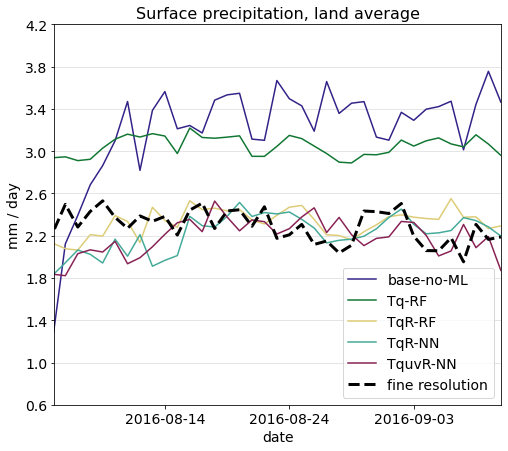

In [30]:
fig = plt.figure()

fig=plt.figure(figsize=(8,7))
plt.style.use('tableau-colorblind10')

downsample_times = [
    diags["TqR-NN"].time.values[0]
] + [t for t in diags["TqR-NN"].time.values if t.hour==0]
subset_times = list(set(downsample_times).intersection(list(verif_physics.time.values)))

diags["base-no-ML"] \
    ["total_precip_to_surface_spatial_mean_physics_land"].sel(time=subset_times).sortby("time") \
    .resample(time='1D').mean('time') \
    .plot(
        label="base-no-ML",
        linewidth=1.5,
        color='#332288'
    )

diags["Tq-RF"] \
    ["total_precip_to_surface_spatial_mean_physics_land"].sortby("time") \
    .resample(time='1D').mean('time') \
    .plot(
        label="Tq-RF",
        linewidth=1.5,
        color='#117733'
    )

diags["TqR-RF"] \
    ["total_precip_to_surface_spatial_mean_physics_land"].sel(time=subset_times).sortby("time") \
    .resample(time='1D').mean('time') \
    .plot(
        label="TqR-RF",
        linestyle="-",
        linewidth=1.5,
        color='#DDCC77'
    )
diags["TqR-NN"] \
["total_precip_to_surface_spatial_mean_physics_land"].sel(time=subset_times).sortby("time") \
    .resample(time='1D').mean('time') \
    .plot(
        label="TqR-NN",
        linestyle="-",
        linewidth=1.5,
        color='#44AA99'
    )
diags["TquvR-NN"] \
["total_precip_to_surface_spatial_mean_physics_land"].sel(time=subset_times).sortby("time") \
    .resample(time='1D').mean('time') \
    .plot(
        label="TquvR-NN",
        linestyle="-",
        linewidth=1.5,
        color='#882255'
    )


verif_physics["total_precip_to_surface_spatial_mean_physics_land"] \
    .sel(time=subset_times) \
    .sortby("time") \
    .plot(
        linestyle="--",
        label="fine resolution",
        linewidth=3,
        color="black",
    )

plt.legend()
plt.xlabel("date", fontsize=14)
plt.ylabel("mm / day", fontsize=14)

plt.xlim(min(subset_times), max(subset_times))
plt.ylim(0.6, 4.2)

plt.grid(True, axis="y", alpha=0.4)
plt.xticks(fontsize=14)

plt.yticks(np.linspace(0.6, 4.2, 10), fontsize=14)
plt.title("Surface precipitation, land average", fontsize=16)
plt.legend(loc="lower right", fontsize=14)

plt.savefig("final_figures/PrecLandTimeSeries.eps", format="eps")